## TP2


### Mise en place de l'environnement

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

### Chargement des données

In [3]:
order_products_prior_specials = pd.read_csv("données/order_products__prior_specials.csv")
order_distance_stores_softmax = pd.read_csv("données/orders_distance_stores_softmax.csv")

In [4]:
merged_order = pd.merge(order_products_prior_specials, order_distance_stores_softmax, on="order_id")
merged_order = merged_order.dropna()

print(merged_order.nunique())
merged_order = merged_order.drop("eval_set", 1)  # car une seule valeur

merged_order.to_csv("données/merged_order.csv")

Unnamed: 0_x              1158441
order_id                   134652
product_id                  24783
add_to_cart_order              98
reordered                       2
special                         4
Unnamed: 0_y               134652
user_id                      1374
store_id                       10
distance                    13736
eval_set                        1
order_number                   98
order_dow                       7
order_hour_of_day              24
days_since_prior_order         31
dtype: int64


C:\Users\Josse\AppData\Local\Temp\ipykernel_14296\2812134702.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  merged_order = merged_order.drop("eval_set", 1)  # car une seule valeur


### Suppression de données

On sélectionne 5% des utilisateurs

In [5]:
all_users = merged_order["user_id"].unique()
nb_users = len(all_users)
reduced_nb_users = nb_users * 5 // 100

restricted_users = np.random.choice(all_users, size=reduced_nb_users)
restricted_order = merged_order.loc[merged_order["user_id"].isin(restricted_users)]

# restricted_order.to_csv("données/restricted_order.csv")

### Séparation des données

In [6]:
test_prop = 0.2
train_df, test_df = train_test_split(restricted_order, test_size=test_prop)

full_train_df = train_df.copy()
full_train_df['set'] = "train"

full_test_df = test_df.copy()
full_test_df['set'] = "test"

full_df = full_train_df.append(full_test_df)
full_df.head()

,Unnamed: 0_x,order_id,product_id,add_to_cart_order,reordered,special,Unnamed: 0_y,user_id,store_id,distance,order_number,order_dow,order_hour_of_day,days_since_prior_order,set
774002,774002,2256902,25256,23,0,30,50860,73765,6,0.603750,72,1,17,1.0,train
591183,591183,1727508,40689,14,0,15,50814,73765,2,1.460757,31,2,15,12.0,train
661438,661438,1933055,10603,4,1,0,53924,78879,6,0.725775,42,6,15,2.0,train
469678,469678,1372570,40571,4,1,0,109651,167957,6,0.761638,17,2,12,4.0,train
252511,252511,740516,19548,10,0,30,110003,168637,1,1.425505,5,0,18,8.0,train


### Visualisation des données

<Figure size 720x720 with 0 Axes>

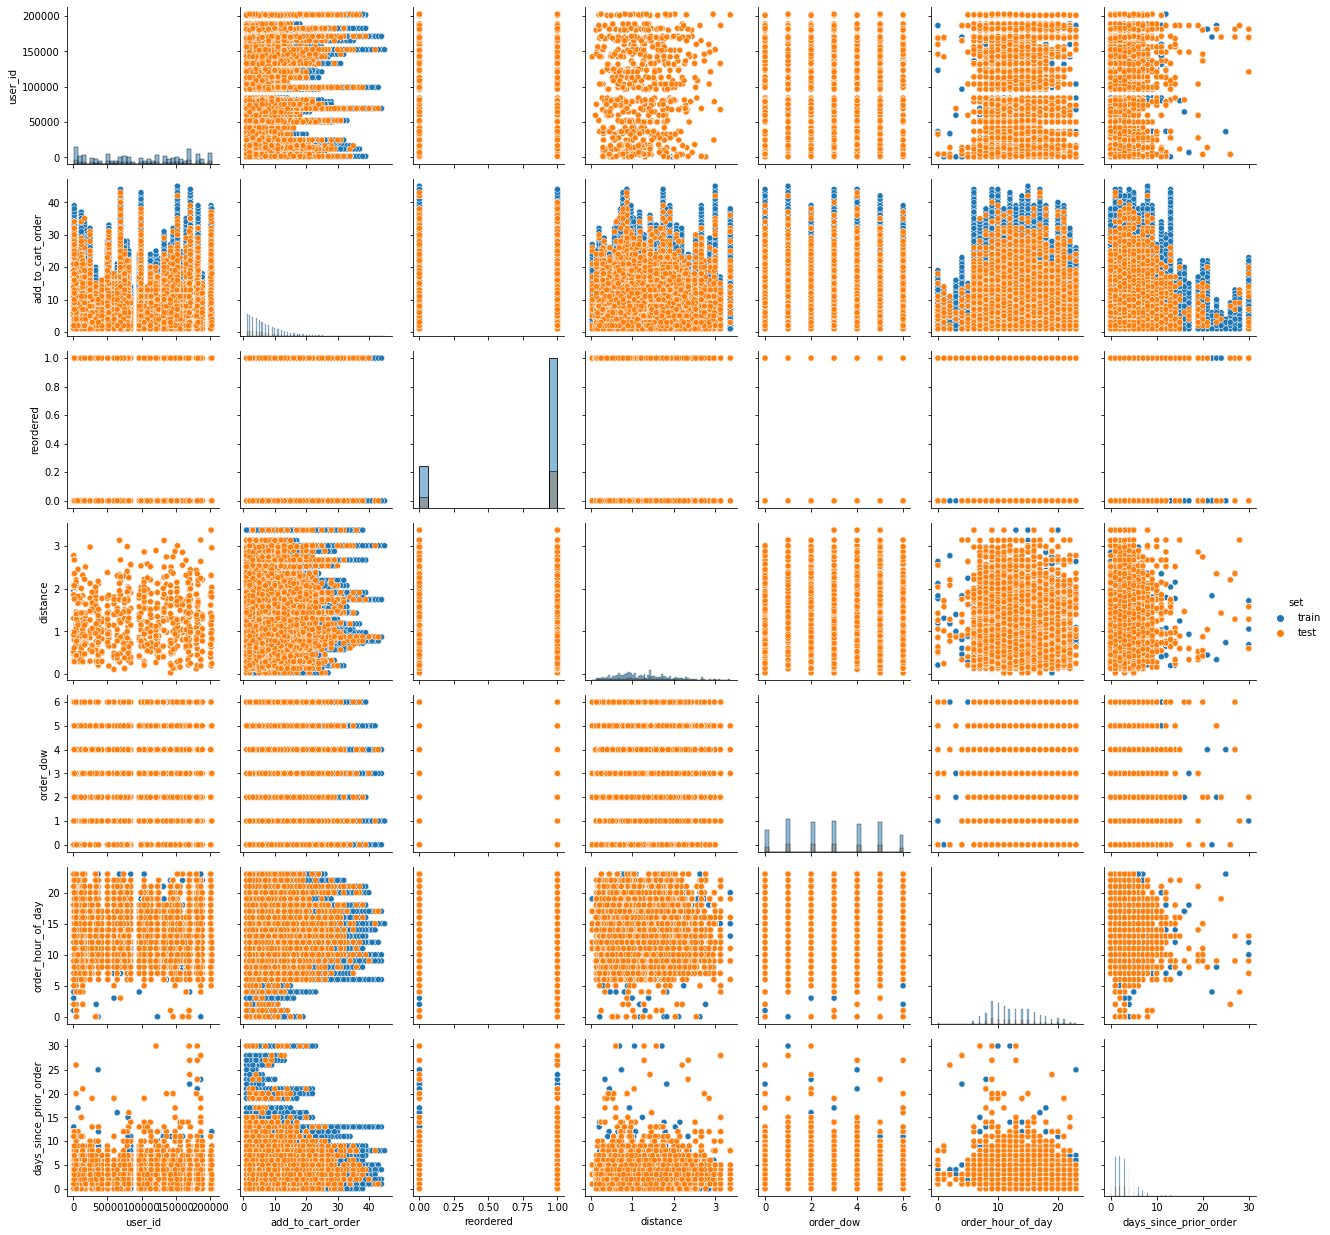

In [7]:
# sns.barplot()
full_df.columns
# Useful columns:
#   add_to_cart_order
#   reordered
#   distance
#   order_number
#   order_dow
#   order_hour_of_day
#   days_since_prior_order
#   set

# hue / style / size

useful_columns = ["user_id", "add_to_cart_order", "reordered", "distance", "order_dow", "order_hour_of_day", "days_since_prior_order", "set"]

# sns.histplot(

# )

fig = plt.figure(figsize=(10, 10))

# g = sns.PairGrid(full_df, hue="set")
g = sns.PairGrid(full_df[useful_columns], hue="set")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend();




### CNN

In [8]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

train_x = train_df.loc[:, train_df.columns != "reordered"]
train_y = train_df["reordered"]

test_x = test_df.loc[:, test_df.columns != "reordered"]
test_y = test_df["reordered"]

layers = [
    (i, j)
    for i in [5, 10, 25, 50, 100]
    for j in [5, 10, 25, 50, 100]
]

params = {
    "hidden_layer_sizes": layers,
    "activation": ["relu"]
}


clf = MLPClassifier(hidden_layer_sizes=(50, 50), activation="relu")
clf.out_activation_ = 'softmax'

clf_hp = GridSearchCV(clf, param_grid=params)
clf_hp.fit(X=train_x, y=train_y)

GridSearchCV(estimator=MLPClassifier(hidden_layer_sizes=(50, 50)),
             param_grid={'activation': ['relu'],
                         'hidden_layer_sizes': [(5, 5), (5, 10), (5, 25),
                                                (5, 50), (5, 100), (10, 5),
                                                (10, 10), (10, 25), (10, 50),
                                                (10, 100), (25, 5), (25, 10),
                                                (25, 25), (25, 50), (25, 100),
                                                (50, 5), (50, 10), (50, 25),
                                                (50, 50), (50, 100), (100, 5),
                                                (100, 10), (100, 25), (100, 50),
                                                (100, 100)]})

In [9]:
from sklearn.metrics import confusion_matrix


best_params = clf_hp.best_params_
pred = clf_hp.predict(test_x)

tn, fp, fn, tp = confusion_matrix(y_true=test_y, y_pred=pred).ravel()

precision = tp / (tp + fp)
recall = tp / (tp + fn)

F1 = (2 * precision * recall) / (precision + recall)

In [10]:
print(best_params)
print(F1)

{'activation': 'relu', 'hidden_layer_sizes': (100, 5)}
